# Dynex Quantum Support Vector Machine (PyTorch layer)

in this example a classical classiﬁcation model, Kernel-Support Vector machine, is implemented as a Quadratic Unconstrained Binary Optimisation problem. Here, data points are classiﬁed by a separating hyperplane while maximizing the function margin. The problem is solved for a public Banknote Authentication dataset.

In [1] the authors performed benchmark tests for a Quantum-SVM on multiple D-Wave Quantum machines. Here are their results:

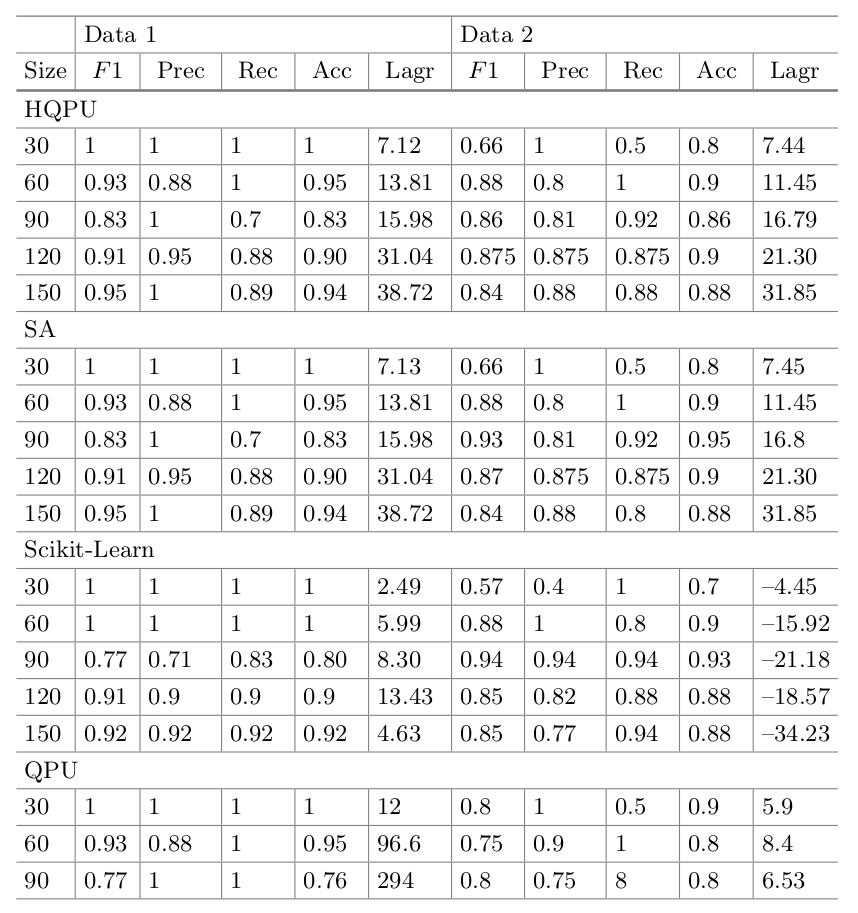

We will demonstrate that the Dynex Neuromorphic Computing platform, by using the Dynex QSVM PyTorch Layer, will significantly outperform these results.

## QSVM using the Dynex QSVM PyTorch Layer

In [2]:
import math
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
from DynexQSVM.QSVM_Layer import QSVM_Layer

## Load Dataset Function

In [4]:
class BankDataset(Dataset):
    def __init__(self, data_file, size):
        training_data = np.loadtxt('./datasets/{}'.format(data_file), delimiter=',')
        training_data = training_data[:size];
        for i in range(len(training_data)):
            if(training_data[i][-1] == 0):
                training_data[i][-1] = -1
        data = training_data[:, :2]
        t = training_data[:, -1]
        x_min, x_max = 1000, 0
        y_min, y_max = 1000, 0
        # rescalling data
        for i in range(len(training_data)):
            x_min = min(data[i][0], x_min)
            x_max = max(data[i][0], x_max)
            y_min = min(data[i][1], y_min)
            y_max = max(data[i][1], y_max)
        for i in range(len(training_data)):
            data[i][0] = (data[i][0] - x_min)/(x_max - x_min)
            data[i][1] = (data[i][1] - y_min)/(y_max - y_min)
        
        self.data = data
        self.target = t	

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        d = self.data[idx]
        t = self.target[idx]
        return d, t

## Initialize the train, validation, and test data loaders with PyTorch

In [5]:
bank_dataset = BankDataset(data_file='banknote_1.txt', size=150)
train_percent = 0.8
train_size = int(len(bank_dataset) * train_percent)
test_size = len(bank_dataset) - train_size; 
train_dataset, test_dataset = torch.utils.data.random_split(bank_dataset, [train_size, test_size])

In [6]:
train_loader = DataLoader(train_dataset, batch_size=1, num_workers=0, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=0, shuffle=False)

## Define Pytorch model with a custom Dynex-QSVM layer

In [7]:
spl = "DNX";    # Sampler to use "DNX" "SA" "EXACT" "QPU" "HQPU"
device = 'cpu'; # Torch device, we don't use GPU but Dynex, therefore set to CPU

class QSVMModel(nn.Module):
    def __init__(self, B,K,C,gamma,xi,dataset,train_percent,spl,mainnet,num_reads,annealing_time):
        super().__init__();
        # Dynex Neuromporphic layer
        self.dnxlayer = QSVM_Layer(B,K,C,gamma,xi,dataset,train_percent,spl,mainnet,num_reads,annealing_time);

    def forward(self, x):
        x = self.dnxlayer(x);
        return x;

## Settings

In [8]:
B = 2;
K = 2;
C = 3;
gamma = 16;
xi = 0.001;

In [9]:
model = QSVMModel(B, K, C, gamma, xi, bank_dataset, train_percent, spl, mainnet=False, num_reads=10000, annealing_time=300)

## Training

In [10]:
EPOCHS = 1
for e in range(0, EPOCHS):
    print('EPOCH',e+1,'of',EPOCHS);
    tp, fp, tn, fn = 0, 0, 0, 0
    # set the model in training mode
    model.train()
    # loop over the training set
    for (x, y) in test_loader:
        # send the input to the device
        (x, y) = (x.to(device), y.to(device))
        # perform a forward pass and calculate the training loss
        pred = model(x);
        if(y == 1):
            if(pred > 0):
                tp += 1
            else:
                fp += 1
        else:
            if(pred < 0):
                tn += 1
            else:
                fn += 1

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_score = tp/(tp + 1/2*(fp+fn))
    accuracy = (tp + tn)/(tp+tn+fp+fn)
    print(f"{precision=} {recall=} {f_score=} {accuracy=}")

EPOCH 1 of 1
[DYNEX] PRECISION SET TO 0.0001
[DYNEX] SAMPLER INITIALISED
[DYNEX|TESTNET] *** WAITING FOR READS ***
╭────────────┬───────────┬───────────────────────────┬─────────┬─────────┬────────────────╮
│ DYNEXJOB   │ ELAPSED   │ WORKERS READ              │ CHIPS   │ STEPS   │ GROUND STATE   │
├────────────┼───────────┼───────────────────────────┼─────────┼─────────┼────────────────┤
│            │           │ *** WAITING FOR READS *** │         │         │                │
╰────────────┴───────────┴───────────────────────────┴─────────┴─────────┴────────────────╯

[DYNEX] FINISHED READ AFTER 0.01 SECONDS
[DYNEX] SAMPLESET READY
precision=1.0 recall=1.0 f_score=1.0 accuracy=1.0


## The Dynex Platorm achieved scores of 1.0 for every metric

## Plot Results

In [11]:
def plot_figure(SVM,dataset,train_percent,sampler_type, img):
    plt.figure()
    cm = plt.cm.RdBu
    data = dataset.data
    t = dataset.target
    N = int(len(dataset)*train_percent)

    xx, yy = np.meshgrid(np.linspace(0.0, 1.0, 80), np.linspace(0.0, 1.0, 80))
    Z = []
    for row in range(len(xx)):
        Z_row = []
        for col in range(len(xx[row])):
            target = np.array([xx[row][col], yy[row][col]])
            Z_row.append(SVM(target))
        Z.append(Z_row)

    cnt = plt.contourf(xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both")

    plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
    plt.colorbar(cnt, ticks=[-1, 0, 1])

    red_sv = []
    blue_sv = []
    red_pts = []
    blue_pts = []

    for i in range(N):
        if(SVM.dnxlayer.alpha[i]):
            if(t[i] == 1):
                blue_sv.append(data[i, :2])
            else:
                red_sv.append(data[i, :2])
        else:
            if(t[i] == 1):
                blue_pts.append(data[i, :2])
            else:
                red_pts.append(data[i, :2])

    plt.scatter([el[0] for el in blue_sv],
                [el[1] for el in blue_sv], color='b', marker='^', edgecolors='k', label="Type 1 SV")

    plt.scatter([el[0] for el in red_sv],
                [el[1] for el in red_sv], color='r', marker='^', edgecolors='k', label="Type -1 SV")

    plt.scatter([el[0] for el in blue_pts],
                [el[1] for el in blue_pts], color='b', marker='o', edgecolors='k', label="Type 1 Train")

    plt.scatter([el[0] for el in red_pts],
                [el[1] for el in red_pts], color='r', marker='o', edgecolors='k', label="Type -1 Train")    
    plt.legend(loc='lower right', fontsize='x-small')
    plt.savefig(f'{img}.jpg')

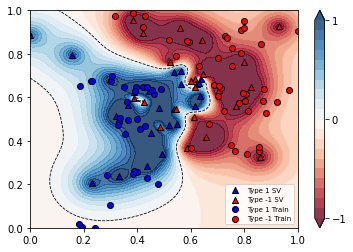

In [12]:
plot_figure(model,bank_dataset,train_percent,spl,"img")

## References

[1] Harshil Singh Bhatia and Frank Phillipson: Performance Analysis of Support Vector Machine Implementations on the D-Wave Quantum Annealer, International Conference on Computational Science, p.84-97, 2021, Springer

[2] Booth, M., Reinhardt, S.P., Roy, A.: Partitioning Optimization Problems for Hybrid Classical/Quantum Execution. Technical report, D-Wave Systems (2017)

[3] Chang, C.C., Lin, C.J.: LIBSVM: a library for support vector machines. ACM Trans. Intell. Syst. Technol. 2, 27:1–27:27.

[4] Chatterjee, R., Yu, T.: Generalized coherent states, reproducing kernels, and quantum support vector machines. Quantum Inf. Comput. 17(15–16), 1292–1306 (2017)

[5] Choi, V.: Minor-embedding in adiabatic quantum computation: I. the parameter setting problem. Quantum Inf. Process. 7(5), 193–209 (2008)

[6] Coﬀrin, C.J.: Challenges with chains: testing the limits of a d-wave quantum annealer for discrete optimization. Technical report, Los Alamos National Lab. (LANL), Los Alamos, NM (United States) (2019)

[7] Willsch, D., Willsch, M., De Raedt, H., Michielsen, K.: Support vector machines on the d-wave quantum annealer. Comput. Phys. Commun. 248, 107006 (2020)